In [1]:
# import libraries
import tensorflow as tf
import numpy as np
import os
import cv2
import random
import matplotlib.pyplot as plt
from tensorflow import keras
# loads classes and functions
from Utils.preporcessing_utils import data_loading 
from Utils.preporcessing_utils import ablation
from Utils.preporcessing_utils import image_preprocessing
from Utils.visualizations_utils import Visualization as vis

2025-09-19 13:03:56.206316: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-09-19 13:03:57.719071: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1758301438.342611  224879 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1758301438.601722  224879 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-09-19 13:04:00.702760: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

### Create Preporcessing Groups By Using Ablation

In [2]:
# create groups using ablation
options = ['apply_background_removal',
           'apply_crop',
           'apply_noise_reduction',
           'apply_contrast_enhancement',
           'apply_edge_enhancement',
           'apply_lbp_texturizer']

In [3]:
# create group of techniques to try
techniques_groups = ablation(options)

In [4]:
# get technique group of only basic preprocessing(resizing)
basic_preprocessing = techniques_groups["Baseline Basic Preporcessing"]
basic_preprocessing

{'apply_background_removal': False,
 'apply_crop': False,
 'apply_noise_reduction': False,
 'apply_contrast_enhancement': False,
 'apply_edge_enhancement': False,
 'apply_lbp_texturizer': False}

### Prepare Image

In [84]:
# Loads data: skip this step if not loading from dataframe  
train_df, test_df = data_loading("train_full.csv", "test_full.csv")
test_df.columns

Index(['image_id', 'image_type', 'image_path', 'series_uid', 'subject_id',
       'study_uid', 'breast_density', 'breast_side', 'image_view',
       'abnormality_type', 'pathology', 'split'],
      dtype='object')

In [7]:
def gets_images_paths(d_set, num_imgs):
    new_data_set = []
    for img in range(num_imgs):
        # gets a random inice
        ind = random.randint(0, len(d_set) - 1)
        
        # gets label and image path
        image_path = test_df["image_path"][ind]
        image_label = test_df["pathology"][ind]
        new_data_set.append([image_path, image_label])

    return new_data_set

### Loads Image

In [64]:
def loads_preprocess(image_path):
    # loads image
    original_img = cv2.imread(image_path)
    
    is_resnet_vgg = True
    # preprocess image
    preprocessed_img = image_preprocessing(original_img, 
                                           basic_preprocessing,
                                           is_resnet_vgg=is_resnet_vgg,
                                           custom_cnn_size=256, 
                                           resnet_vgg_size=224
                                          )
    # convert image to array and reshape
    preprocessed_img = tf.keras.preprocessing.image.img_to_array(preprocessed_img)
    preprocessed_img = np.expand_dims(preprocessed_img, axis=0) / 255.0  # shape (1, 224, 224, 3)
    
    return preprocessed_img 

### Makes Predictions

In [65]:
def make_predictions(threshold, model, img):
    # get model's prediction probabilities
    y_pred_prob = model.predict(img)
    if y_pred_prob >= threshold:
        prediction = "Malignant"
    else:
        prediction = "Benign"
    return img, prediction

### Load Model 

In [83]:
# Load model saved locally
model_name = "Models/VGGModel/vgg16:10_-_baseline_basic_preporcessing_-_(denseu=256,_dropout=0.2,_layer=256).keras"
vgg_model = keras.models.load_model(model_name)

### Inference 

In [81]:
# Data needed
# optimal threshold
optimal_threshold = 0.384275 # best threshold found in iteration 5 

# images dataset: it only needs to contain two columns named "image_path" and "pathology"
test_df.head(2) 

,image_id,image_type,image_path,series_uid,subject_id,study_uid,breast_density,breast_side,image_view,abnormality_type,pathology,split
0,62869_00,full,CBIS-DDSM_Clean_Data/labeled_images_png/1.3.6....,1.3.6.1.4.1.9590.100.1.2.100522099512256189513...,Mass-Test_P_00576_LEFT_MLO,1.3.6.1.4.1.9590.100.1.2.286066835611001826026...,2.0,LEFT,MLO,mass,MALIGNANT,test
1,45647_00,full,CBIS-DDSM_Clean_Data/labeled_images_png/1.3.6....,1.3.6.1.4.1.9590.100.1.2.100522676511025180541...,Mass-Test_P_01510_RIGHT_MLO,1.3.6.1.4.1.9590.100.1.2.403479789212123359501...,4.0,RIGHT,MLO,mass,BENIGN,test


In [82]:
# prepare image the dataset 
new_data_set = gets_images_paths(test_df, 8)

In [73]:
visual_dict = {}
for i, (im_path, label) in enumerate(new_data_set):
    
    # loads and preprocess image
    preprocessed_img = loads_preprocess(im_path)
    # makes prediction
    img, prediction_prob = make_predictions(optimal_threshold, vgg_model, preprocessed_img)

    # creates images dictionary
    name = f"Prediction{i}: {prediction_prob.upper()} | True: {label.upper()}"
    visual_dict[name] = img[0] 
    

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


In [74]:
len(visual_dict)

8

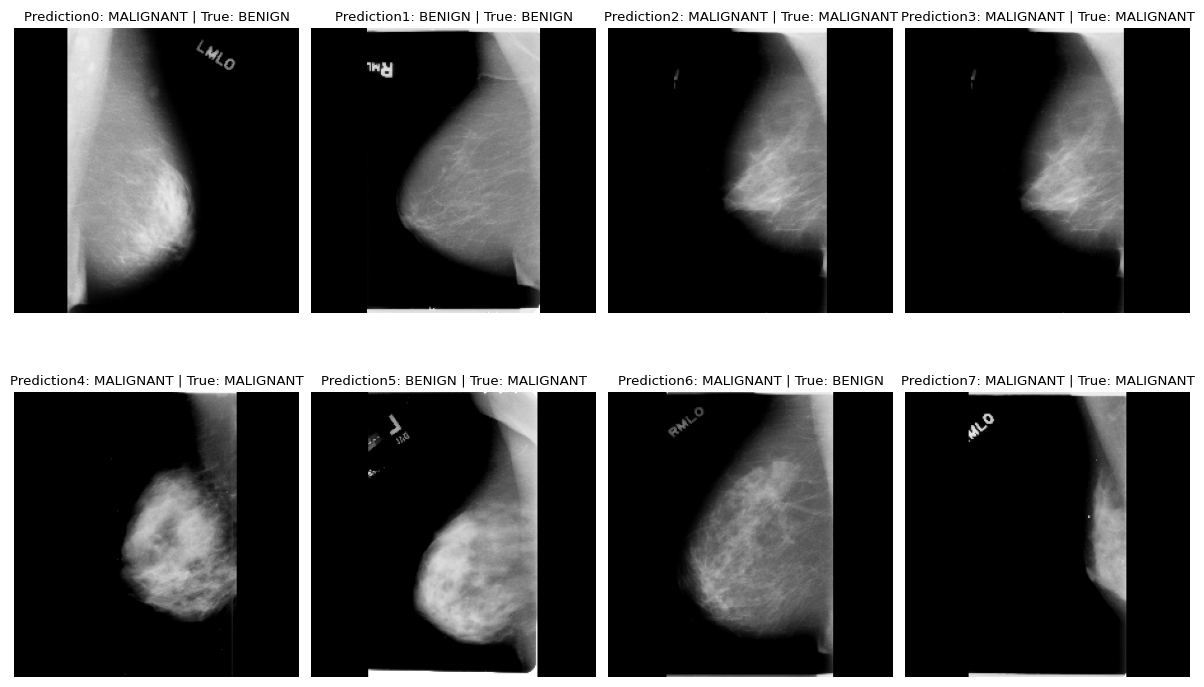

In [75]:
vis.vis_plots(visual_dict)